In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("./data/labeled_data.csv")
data = df.drop(columns=["_id", "TimeStamp","PART_FACT_PLAN_DATE", "PART_FACT_SERIAL",
                        "EQUIP_NAME", "EQUIP_CD",
                        "Mold_Temperature_1","Mold_Temperature_2","Mold_Temperature_5","Mold_Temperature_6",
                        "Mold_Temperature_7","Mold_Temperature_8","Mold_Temperature_9","Mold_Temperature_10",
                        "Mold_Temperature_11","Mold_Temperature_12","Barrel_Temperature_7","Switch_Over_Position"])
cn7 = data[(data["PART_NAME"] == "CN7 W/S SIDE MLD'G RH") | (data["PART_NAME"] == "CN7 W/S SIDE MLD'G LH")]

In [3]:
data["PART_NAME"].value_counts()

PART_NAME
CN7 W/S SIDE MLD'G RH        3371
CN7 W/S SIDE MLD'G LH        3365
RG3 MOLD'G W/SHLD, LH         628
RG3 MOLD'G W/SHLD, RH         628
SP2 CVR ROOF RACK CTR, RH       2
JX1 W/S SIDE MLD'G RH           2
Name: count, dtype: int64

In [4]:
cn7 = cn7.drop(columns=["PART_NAME"])

In [5]:
cn7 = cn7.replace("Y", 100).replace("N", 0)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24740\1682076179.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cn7 = cn7.replace("Y", 100).replace("N", 0)


In [6]:
cn7["Reason"].unique()

array([nan, '가스', '미성형', '초기허용불량'], dtype=object)

In [7]:
cn7["Reason"].value_counts()

Reason
초기허용불량    20
가스        13
미성형        6
Name: count, dtype: int64

In [8]:
cn7["Reason"] = cn7["Reason"].fillna(0)

In [9]:
cn7["Reason"] = cn7["Reason"].replace("가스", 1).replace("미성형", 2).replace("초기허용불량", 3)

C:\Users\Admin\AppData\Local\Temp\ipykernel_24740\640897969.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cn7["Reason"] = cn7["Reason"].replace("가스", 1).replace("미성형", 2).replace("초기허용불량", 3)


In [10]:
cn7_Y = cn7[cn7["PassOrFail"] == 100]
cn7_N = cn7[cn7["PassOrFail"] == 0]

In [11]:
def remove_outliers(df, column):
    # 1사분위수(Q1)와 3사분위수(Q3) 계산
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    
    # IQR 계산
    IQR = Q3 - Q1
    
    # 이상치 범위 설정
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # 이상치 제거
    filtered_df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    
    return filtered_df
cn7_Y = remove_outliers(cn7_Y, "Injection_Time")
cn7_Y = remove_outliers(cn7_Y, "Plasticizing_Time")
cn7_Y = remove_outliers(cn7_Y, "Cycle_Time")
cn7_Y = remove_outliers(cn7_Y, "Max_Injection_Speed")
cn7_Y = remove_outliers(cn7_Y, "Mold_Temperature_3")
cn7 = pd.concat([cn7_Y, cn7_N], ignore_index=True)

In [12]:
cn7_Y = remove_outliers(cn7_Y, "Injection_Time")
cn7_Y = remove_outliers(cn7_Y, "Plasticizing_Time")
cn7_Y = remove_outliers(cn7_Y, "Cycle_Time")
cn7_Y = remove_outliers(cn7_Y, "Max_Injection_Speed")
cn7_Y = remove_outliers(cn7_Y, "Mold_Temperature_3")

In [13]:
cn7 = pd.concat([cn7_Y, cn7_N], ignore_index=True)

In [14]:
cn7_reason = cn7.copy()
cn7 = cn7.drop(columns=["Reason"])

In [15]:
from sklearn.model_selection import train_test_split
X = cn7.drop(columns=["PassOrFail"])
y = cn7["PassOrFail"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4601, 24), (1972, 24), (4601,), (1972,))

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.3, random_state=42)

In [17]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_val_scaled = ss.transform(X_val)
X_test_scaled = ss.transform(X_test)

In [18]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

model = LinearRegression()
model.fit(X_train_scaled, y_train)
val_pred = model.predict(X_val_scaled)
r2 = r2_score(y_val, val_pred)
mae = mean_absolute_error(y_val, val_pred)
mse = mean_squared_error(y_val, val_pred)
print(mae, mse, r2)


# 각 독립변수의 계수와 절편 확인
print("회귀계수:", model.coef_)    # 각 독립변수에 대한 계수 출력
print("절편:", model.intercept_)   # 상수항(절편) 출력

2.9158239166387636 363.8564075145791 -3.2240854030430475
회귀계수: [-7.81434500e+00 -7.66255907e+00  4.29880155e+00  6.27668971e+00
 -1.08499606e+00 -2.78613887e-02 -2.39865365e+00 -1.15463195e-14
 -8.12948928e+00  6.57163854e-01  3.09803994e+00  3.58490232e+00
  5.30547422e-01 -3.36432595e+00 -7.86717298e-01  3.95853826e-02
  1.51082287e-01 -1.95752514e-01  3.29131218e-01 -1.59613818e-01
 -1.71604075e-01 -4.84048485e-01 -1.03016707e+00  9.59805159e-01]
절편: 99.5962732919251


In [19]:
import numpy as np

# 50점을 기준으로 회귀 예측 값을 이진 분류 (양품: 1, 불량: 0)
predicted_classes = np.where(val_pred > 95, 1, 0)

# 실제 y_val도 50점을 기준으로 이진 분류
y_val_classes = np.where(y_val > 95, 1, 0)

# 두 클래스 배열이 같은지 확인하여 정확도 계산
accuracy = np.mean(predicted_classes == y_val_classes)
print("분류 정확도:", accuracy)


분류 정확도: 0.9833454018826937


In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predicted_classes, y_val_classes)
cm

array([[   8,   19],
       [   4, 1350]], dtype=int64)

In [21]:

# 모델 학습 후 회귀계수 획득 (이미 model.fit()을 수행했다고 가정)
coefficients = model.coef_

# 독립변수와 회귀계수로 DataFrame 생성
df_coeff = pd.DataFrame({'독립변수': X.columns, '회귀계수': coefficients, "제곱" : coefficients * coefficients})

# 회귀계수를 기준으로 내림차순 정렬 (가장 큰 영향력부터 보고자 할 때)
df_coeff_sorted = df_coeff.sort_values(by='제곱', ascending=False)

df_coeff_sorted

,독립변수,회귀계수,제곱
8,Max_Injection_Speed,-8.129489e+00,6.608860e+01
0,Injection_Time,-7.814345e+00,6.106399e+01
1,Filling_Time,-7.662559e+00,5.871481e+01
3,Cycle_Time,6.276690e+00,3.939683e+01
2,Plasticizing_Time,4.298802e+00,1.847969e+01
11,Max_Injection_Pressure,3.584902e+00,1.285152e+01
13,Max_Back_Pressure,-3.364326e+00,1.131869e+01
10,Average_Screw_RPM,3.098040e+00,9.597851e+00
6,Plasticizing_Position,-2.398654e+00,5.753539e+00
4,Clamp_Close_Time,-1.084996e+00,1.177216e+00


In [22]:
col_list = ["Max_Injection_Speed", "Injection_Time", "Filling_Time", "Cycle_Time", "Plasticizing_Time" ,"Max_Injection_Pressure",
"Max_Back_Pressure", "Average_Screw_RPM", "Plasticizing_Position", "Reason"]

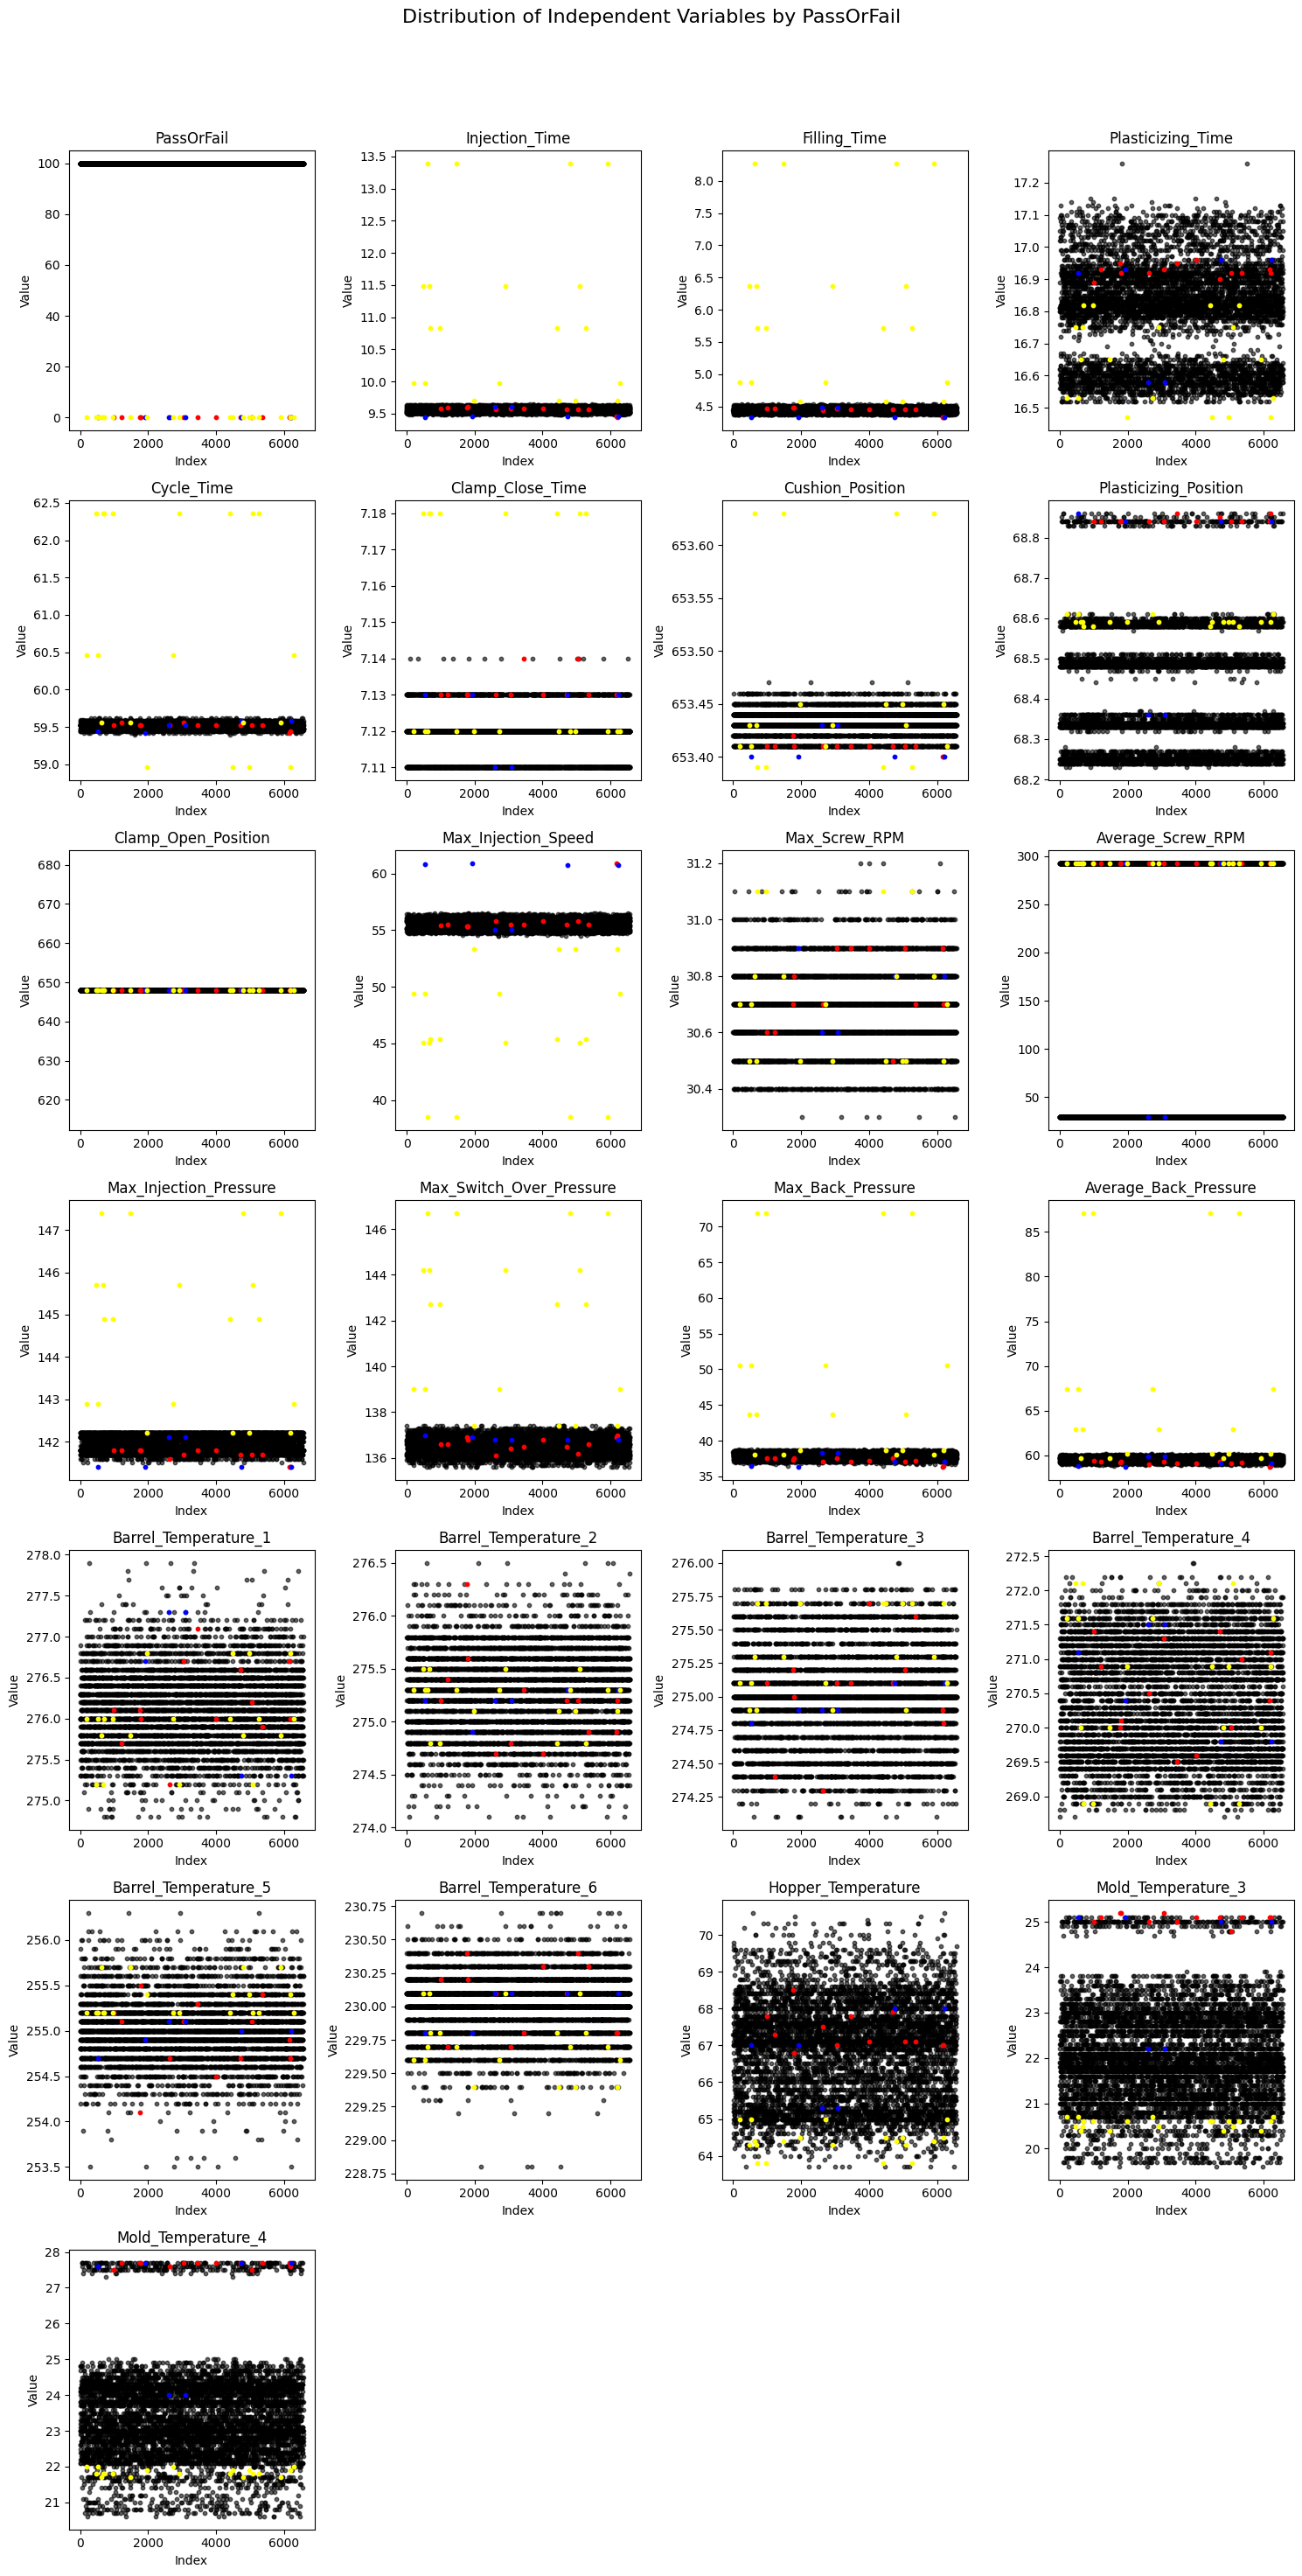

In [23]:
import matplotlib.pyplot as plt

# 필요한 데이터 프레임 복사
tmp = cn7_reason.copy()
tmp["Reason"].value_counts()

# 인덱스 섞기 (불량이 끝에 몰려있어 보기 힘들었음)
tmp = tmp.sample(frac=1, random_state=42).reset_index(drop=True)

# 독립 변수와 종속 변수 분
y = tmp["Reason"]
X = tmp.drop(columns=["Reason"])

# 그래프 설정
fig, axes = plt.subplots(nrows=7, ncols=4, figsize=(15, 30))
axes = axes.flatten()
fig.suptitle("Distribution of Independent Variables by PassOrFail", fontsize=16)

# 독립 변수별 산점도 생성
for i, column in enumerate(X.columns):
    ax = axes[i]
    ax.scatter(X.index[y == 0], X[column][y == 0], label="Pass", color="black", alpha=0.6, s=10)
    ax.scatter(X.index[y == 1], X[column][y == 1], label="Fail", color="red", alpha=1, s=10)
    ax.scatter(X.index[y == 2], X[column][y == 2], label="Fail", color="blue", alpha=1, s=10)
    ax.scatter(X.index[y == 3], X[column][y == 3], label="Fail", color="yellow", alpha=1, s=10)
    ax.set_title(column)
    ax.set_xlabel("Index")
    ax.set_ylabel("Value")

# 빈 그래프 제거
for j in range(len(X.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [24]:
tmp

,PassOrFail,Reason,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,...,Average_Back_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4
0,100,0,9.55,4.44,17.049999,59.520000,7.13,653.419983,68.480003,647.98999,...,59.700001,275.799988,275.100006,274.899994,269.899994,254.199997,229.899994,67.300003,22.500000,23.500000
1,100,0,9.53,4.41,16.809999,59.480000,7.12,653.440002,68.250000,647.98999,...,59.400002,275.299988,275.500000,274.899994,269.399994,254.800003,230.100006,67.000000,21.799999,22.900000
2,100,0,9.64,4.52,16.760000,59.580002,7.12,653.460022,68.589996,647.98999,...,59.799999,275.299988,275.000000,274.399994,270.399994,254.600006,230.000000,65.000000,20.799999,22.100000
3,100,0,9.59,4.47,16.600000,59.520000,7.11,653.429993,68.330002,647.98999,...,59.700001,275.799988,275.500000,275.000000,268.799988,255.300003,229.600006,64.599998,21.000000,23.299999
4,100,0,9.55,4.44,17.090000,59.520000,7.12,653.409973,68.500000,647.98999,...,59.700001,276.299988,275.399994,274.899994,270.600006,254.899994,230.100006,69.800003,23.700001,24.799999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6568,100,0,9.56,4.44,16.639999,59.520000,7.11,653.429993,68.339996,647.98999,...,59.700001,275.500000,275.399994,275.000000,270.799988,254.699997,230.500000,66.300003,21.000000,22.299999
6569,100,0,9.52,4.40,16.799999,59.459999,7.12,653.440002,68.250000,647.98999,...,59.299999,276.200012,275.100006,275.000000,271.200012,254.800003,230.199997,67.800003,21.700001,22.900000
6570,100,0,9.53,4.41,16.790001,59.480000,7.12,653.440002,68.250000,647.98999,...,59.299999,275.799988,274.399994,274.600006,269.899994,254.699997,230.300003,67.199997,21.799999,23.000000
6571,100,0,9.52,4.41,16.870001,59.480000,7.12,653.440002,68.250000,647.98999,...,59.200001,276.500000,275.500000,275.500000,269.700012,255.100006,230.100006,67.300003,21.600000,22.700001


In [25]:
mean_v = tmp[tmp["PassOrFail"] == 100]["Max_Injection_Speed"].mean()

In [26]:
tmp["Score"] = abs(tmp["Max_Injection_Speed"] - mean_v)

In [27]:
tmp.sort_values("Score")

,PassOrFail,Reason,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Plasticizing_Position,Clamp_Open_Position,...,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3,Mold_Temperature_4,Score
3286,100,0,9.55,4.44,16.930000,59.480000,7.12,653.429993,68.480003,647.98999,...,276.299988,274.799988,275.200012,270.100006,255.000000,230.000000,68.199997,23.000000,24.200001,0.001454
2289,100,0,9.59,4.47,16.879999,59.520000,7.12,653.450012,68.580002,647.98999,...,275.700012,274.899994,274.799988,269.799988,254.899994,230.100006,66.500000,22.200001,23.400000,0.001454
1083,100,0,9.56,4.45,16.900000,59.520000,7.12,653.429993,68.480003,647.98999,...,276.299988,274.700012,275.000000,271.399994,254.800003,229.800003,68.400002,22.900000,24.200001,0.001454
416,100,0,9.58,4.46,16.920000,59.520000,7.12,653.409973,68.839996,647.98999,...,275.899994,275.000000,275.100006,270.899994,255.300003,229.600006,67.800003,25.000000,27.500000,0.001454
2278,100,0,9.59,4.48,16.900000,59.560001,7.12,653.440002,68.589996,647.98999,...,275.299988,274.700012,274.399994,271.500000,255.000000,230.000000,68.000000,23.400000,24.600000,0.001454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,0,3,11.49,6.37,16.750000,62.360001,7.18,653.429993,68.589996,647.98999,...,275.200012,275.500000,274.899994,272.100006,255.199997,230.100006,64.300003,20.500000,21.799999,10.398548
622,0,3,13.39,8.27,16.650000,59.560001,7.12,653.630005,68.589996,647.98999,...,275.799988,275.299988,275.299988,270.000000,255.699997,229.699997,64.400002,20.400000,21.700001,16.998546
4806,0,3,13.39,8.27,16.650000,59.560001,7.12,653.630005,68.589996,647.98999,...,275.799988,275.299988,275.299988,270.000000,255.699997,229.699997,64.400002,20.400000,21.700001,16.998546
1470,0,3,13.39,8.27,16.650000,59.560001,7.12,653.630005,68.589996,647.98999,...,275.799988,275.299988,275.299988,270.000000,255.699997,229.699997,64.400002,20.400000,21.700001,16.998546


In [28]:
tmp.columns

Index(['PassOrFail', 'Reason', 'Injection_Time', 'Filling_Time',
       'Plasticizing_Time', 'Cycle_Time', 'Clamp_Close_Time',
       'Cushion_Position', 'Plasticizing_Position', 'Clamp_Open_Position',
       'Max_Injection_Speed', 'Max_Screw_RPM', 'Average_Screw_RPM',
       'Max_Injection_Pressure', 'Max_Switch_Over_Pressure',
       'Max_Back_Pressure', 'Average_Back_Pressure', 'Barrel_Temperature_1',
       'Barrel_Temperature_2', 'Barrel_Temperature_3', 'Barrel_Temperature_4',
       'Barrel_Temperature_5', 'Barrel_Temperature_6', 'Hopper_Temperature',
       'Mold_Temperature_3', 'Mold_Temperature_4', 'Score'],
      dtype='object')

In [67]:
tmp["Score_2"] = 0

In [68]:
tmp.loc[tmp["Plasticizing_Position"] > 68.7, "Score_2"] = 10

In [69]:
scaled_tmp = tmp[["Score", "Score_2"]]

In [76]:
from sklearn.preprocessing import StandardScaler
ss = MinMaxScaler()
scaled_tmp = ss.fit_transform(scaled_tmp)

ValueError: Expected 2D array, got 1D array instead:
array=[0.01785953 0.01339456 0.0266593  ... 0.01339456 0.01785953 0.04018385].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [71]:
scaled_tmp

array([[0.01785953, 0.        ],
       [0.01339456, 0.        ],
       [0.0266593 , 0.        ],
       ...,
       [0.01339456, 0.        ],
       [0.01785953, 0.        ],
       [0.04018385, 0.        ]])

In [72]:
scaled_tmp = list(map(lambda X : X[0] + X[1], scaled_tmp)) 

In [73]:
scaled_tmp

[0.017859528084965912,
 0.013394560903183106,
 0.02665929611209338,
 0.01772970239069339,
 0.022324324945666062,
 0.017859528084965912,
 0.013264735208910269,
 0.01772970239069339,
 0.008929764042482956,
 0.013264735208910269,
 0.040183853030631975,
 0.013394560903183106,
 0.026789121806365897,
 0.013264735208910269,
 0.031124263293876183,
 0.03125408898814902,
 0.0,
 0.013264735208910269,
 0.03125408898814902,
 0.026789121806365897,
 0.022194499251393225,
 0.026789121806365897,
 0.026789121806365897,
 0.022324324945666062,
 0.022194499251393225,
 0.013394560903183106,
 0.01772970239069339,
 0.013264735208910269,
 0.013264735208910269,
 0.022194499251393225,
 0.022194499251393225,
 0.01772970239069339,
 0.022194499251393225,
 0.013264735208910269,
 0.026789121806365897,
 0.026789121806365897,
 0.031124263293876183,
 0.013264735208910269,
 0.026789121806365897,
 0.040183853030631975,
 0.03558906015457634,
 0.0,
 0.01772970239069339,
 0.01772970239069339,
 0.017859528084965912,
 0.008799

In [74]:
tmp = tmp.drop(columns=["Score", "Score_2"])
tmp["Score"] = scaled_tmp

In [79]:
tmp[["PassOrFail", "Score", "Reason"]].sort_values("Score", ascending=False)[:50]

,PassOrFail,Score,Reason
6175,0,2.000000,1
1923,0,2.000000,2
535,0,1.995535,2
6200,0,1.995535,1
6222,0,1.991070,2
4738,0,1.991070,2
4649,100,1.772292,0
5569,100,1.772292,0
6328,100,1.772292,0
777,100,1.772292,0
